# Implementing Shor's Algorithm in Qiskit

<img src="./shor_circuit_1.svg" style="background-color:white">

Shor's algorithm is a quantum algorithm for integer factorization, an essential problem in cryptography. This notebook provides a step-by-step implementation of Shor's algorithm, highlighting the concepts and quantum mechanics behind it. 

You'll learn:
- How Shor's algorithm works
- How to construct the quantum circuit for period-finding
- How to run Shor's algorithm using Qiskit

You can set the number of qubits for the circuit, making this implementation flexible for various scenarios.
## Background: Why Factorization?

The security of many cryptographic systems (e.g., RSA) relies on the difficulty of factoring large integers. Shor's algorithm uses quantum mechanics to perform this task efficiently, threatening the basis of classical cryptography.

The algorithm consists of two parts:
1. **Classical Preprocessing**: Reduction of the problem to finding the period of a modular function.
2. **Quantum Period-Finding**: Use of quantum superposition and interference to determine the period of the function.

We implement both parts here.


In [3]:
# Import necessary libraries
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import gcd
from fractions import Fraction
import numpy as np

## Step 1: Classical Preprocessing

Given an integer $N$, Shor's algorithm attempts to find its prime factors. We:
1. Pick a random number $a$ such that $1 < a < N$.
2. Compute $\text{gcd}(a, N)$. If it is not 1, we already have a factor!
3. Use quantum computation to find the period $r$ of the function:
   \begin{equation}
   f(x) = a^x \mod N
   \end{equation}

   If $r$ is found, the factors of $N$ are:
   \begin{equation}
   \text{Factors} = \text{gcd}(a^{r/2} \pm 1, N)
   \end{equation}


In [4]:
import random

def classical_preprocessing(N):
    """Perform the classical preprocessing for Shor's algorithm."""
    
    """ what we should do
    # Pick a random number a such that 1 < a < N
    a = random.randint(2, N - 1)
    print(f"Chosen a: {a}")
    
    # Compute gcd(a, N)
    factor = gcd(a, N)
    if factor != 1:
        print(f"Found factor classically: {factor}")
        return factor, None
    """

    # what we do, for simplicity
    a = 7
    
    return a, N



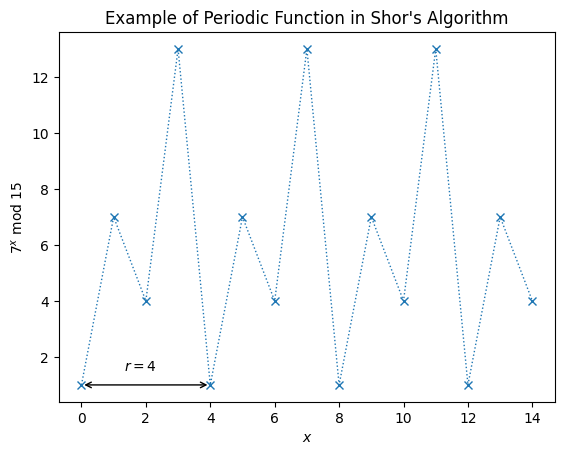

In [5]:
import matplotlib.pyplot as plt

N_const = 15
a = 7

# Calculate the plotting data
xvals = np.arange(N_const)
yvals = [np.mod(a**x, N_const) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N_const}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## Step 2: Quantum Period-Finding

The period-finding component uses a quantum circuit to find the period $r$ of $f(x) = a^x \mod N$. This involves:
1. Preparing a superposition of states.
2. Applying a unitary operator to encode the function $f(x)$.
3. Performing a quantum Fourier transform (QFT) to extract the period.

We construct the circuit step by step below.

In this example we will solve the period finding problem for $a=7$ and $N=15$. We provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation. To create $U^x$, we will simply repeat the circuit $x$ times. In the next section we will discuss a general method for creating these circuits efficiently. The function `c_amod15` returns the controlled-U gate for `a`, repeated `power` times.


In [6]:
# a sarò un valore coprimo con N, ossia non ha altri fattori in comune con N che non sia 1
# una volta accertati che a sia coprimo con N, per power volte, calcoliamo il valore di a^power mod N
# in questa funzione particolare non si applica davvero la moltiplicazione controllata
# ma si mappa il valore di questa attraverso uno swap


# Phase kickback = il qubit di controllo “prende” la fase generata da 𝑈
# U sul registro di lavoro, pur non modificando quel registro.
# È il meccanismo chiave che permette alla QPE, e quindi a Shor, di trasferire l’informazione di periodo dal lavoro al registro di fase, rendendo possibile la misura finale.

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [7]:
# Specify variables
N_COUNT = 8  # number of counting qubits (i.e., phase register)
a = 7

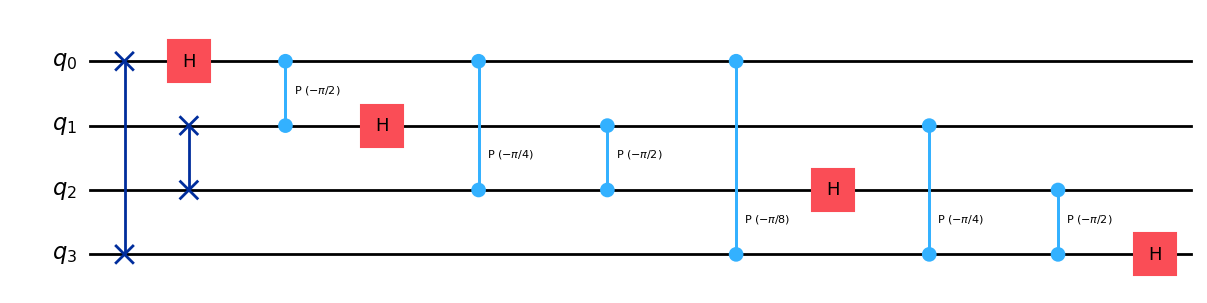

In [8]:
def qft(n):
    """n-qubit QFT"""

    # add your code here

def qft_dagger(n):
    """n-qubit QFTdagger"""
    qc = QuantumCircuit(n)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    for i in range(n):
        for j in range(i):
            qc.cp( -np.pi / 2**(i-j), i, j)
        qc.h(i)
    qc.name = "QFT"
    return qc

    # add your code here

#qft(4).draw(fold=-1, output="mpl")
qft_dagger(4).draw(fold=-1, output="mpl")

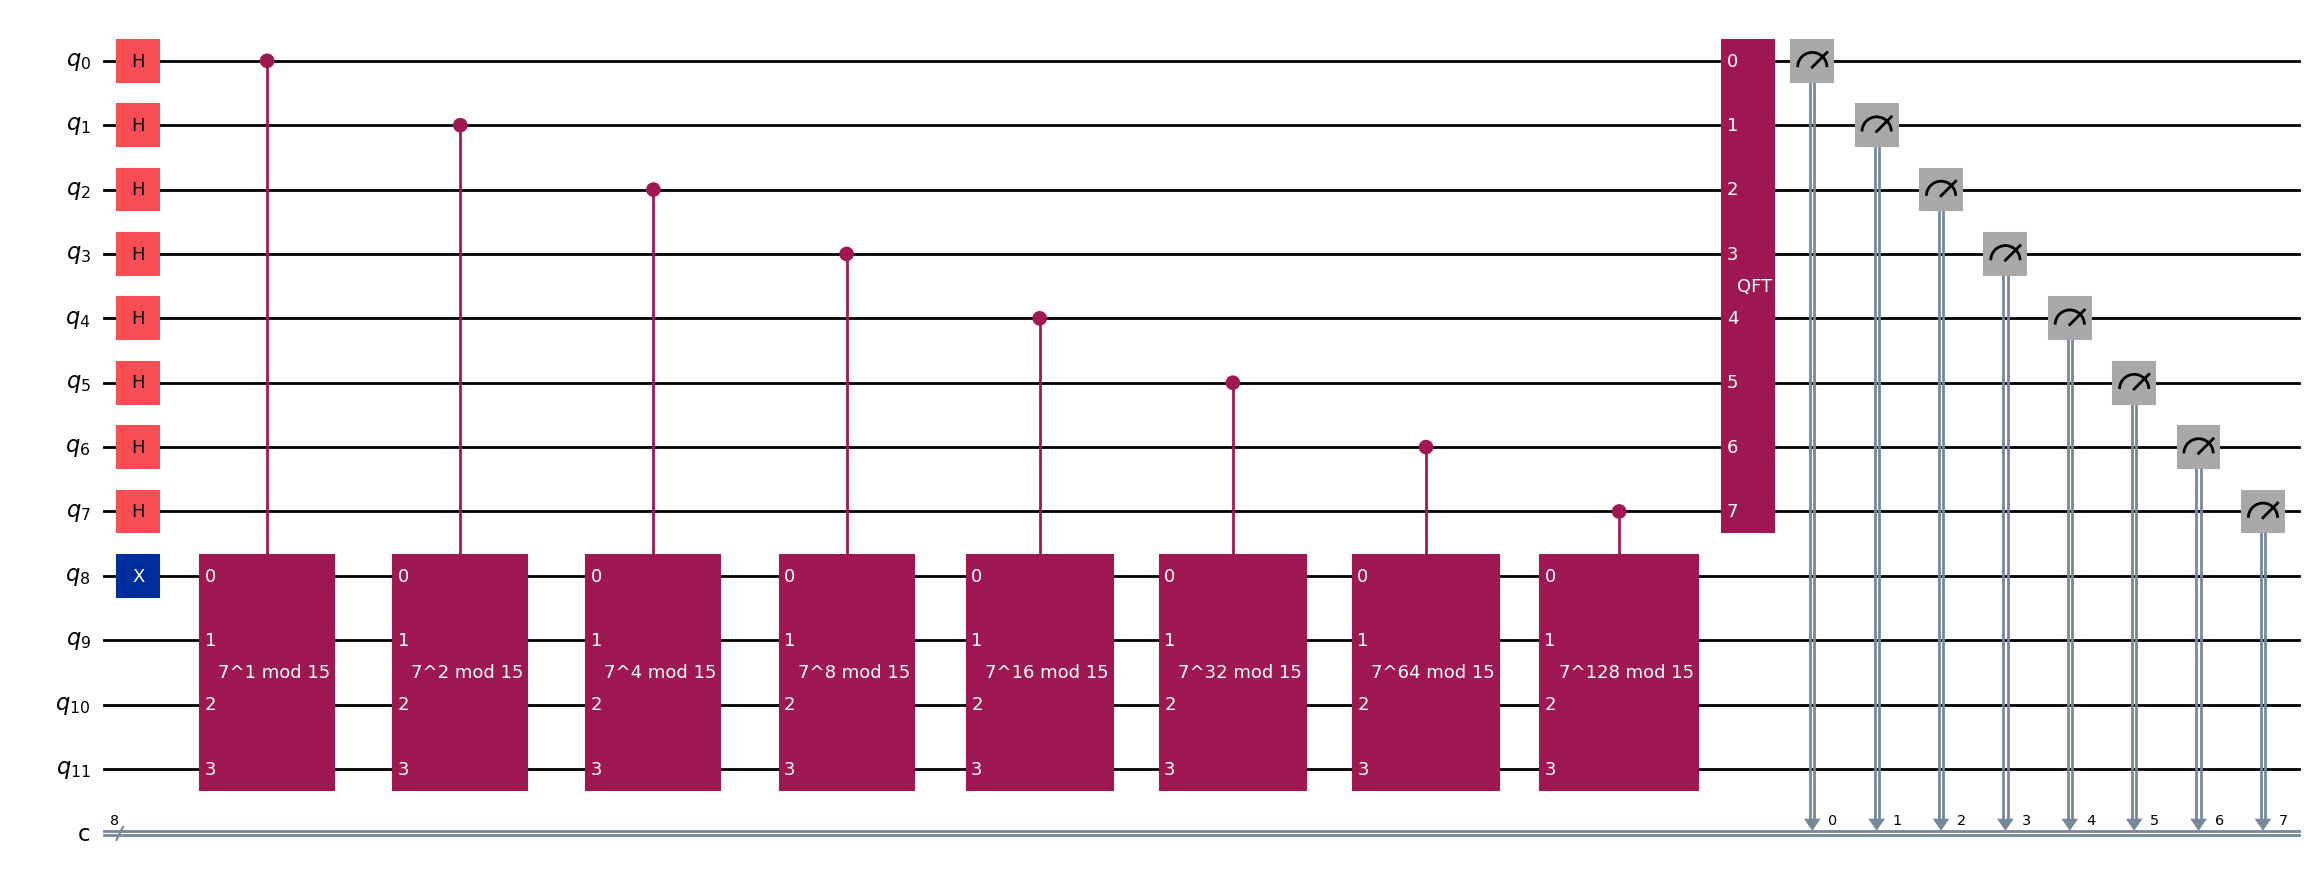

In [9]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)
# And auxiliary register in state |1>
qc.x(N_COUNT)
# Do controlled-U operations
for i in range(N_COUNT):
    qc.append(c_amod15(a, 2**i), [i] + [x + N_COUNT for x in range(4)])
    # [i] è il qubit di controllo, che nella tua funzione è uno dei qubit di contatore.
    # [x + N_COUNT for x in range(4)] rappresenta i qubit ausiliari su cui l'operatore viene applicato,
    #  che sono qubit dal N_COUNT fino a N_COUNT+4 inclusi.
# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))
# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output="mpl")  # -1 means 'do not fold'


## Step 3: Running the Quantum Circuit

We run the quantum circuit. These results are then processed classically to deduce the period $r$.


In [10]:
# get a fake backend

from qiskit_ibm_runtime.fake_provider import FakeParisV2
backend = FakeParisV2()  # emulates Paris quantum computer
backend

In [11]:
# use the AerSimulator backend
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [12]:
# get a real backend

#from qiskit_ibm_runtime import QiskitRuntimeService
 
#service = QiskitRuntimeService(channel="ibm_quantum", token="<REPLACE_WITH_MY_IBM_QUANTUM_TOKEN>")
#backend = service.least_busy(simulator=False, operational=True)
#backend

In [13]:
def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    # Circuits must obey the ISA of the backend.
    # Convert to ISA circuits
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job
    

In [14]:
def get_counts(job):
    result = job.result()
    # Get results for the first (and only) PUB
    pub_result = result[0]
    
    # Get counts from the classical register "c".
    counts = pub_result.data.c.get_counts()
    return counts

## Step 4: Deduce Factors from Period

Using the period $r$, we deduce the factors of $N$ classically. If the period is not found or is invalid, the process is repeated.


In [15]:
def deduce_factors(a, N, counts):
    """Deduce factors of N from the measurement results."""
    # Extract the most frequent result
    measured = max(counts, key=counts.get)
    phase = int(measured, 2) / (2**len(measured))
    
    # Use the phase to calculate the period
    r = Fraction(phase).limit_denominator(N).denominator
    print(f"Estimated period r: {r}")
    
    # Compute the factors
    if r % 2 != 0 or pow(a, r // 2, N) == -1 % N:
        print("Period invalid, retrying...")
        return None, None
    
    factor1 = gcd(pow(a, r // 2) - 1, N)
    factor2 = gcd(pow(a, r // 2) + 1, N)
    return factor1, factor2


## Run Period finding!

Let's see the results for $N=15$, $a=7$.


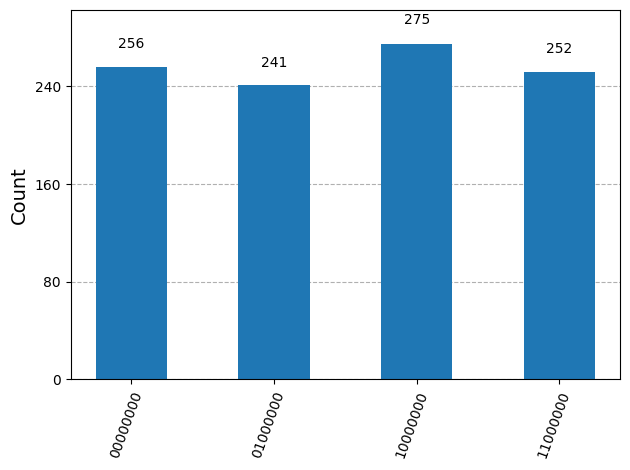

In [16]:
job = run_circuit(qc, backend)
counts = get_counts(job)
plot_histogram(counts)

In [20]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)



            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  01000000(bin) =  64(dec)   64/256 = 0.25


   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.25      1/4            4


(array([1.66666667, 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.66666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.33333333]),
 array([1.  , 1.15, 1.3 , 1.45, 1.6 , 1.75, 1.9 , 2.05, 2.2 , 2.35, 2.5 ,
        2.65, 2.8 , 2.95, 3.1 , 3.25, 3.4 , 3.55, 3.7 , 3.85, 4.  ]),
 <BarContainer object of 20 artists>)

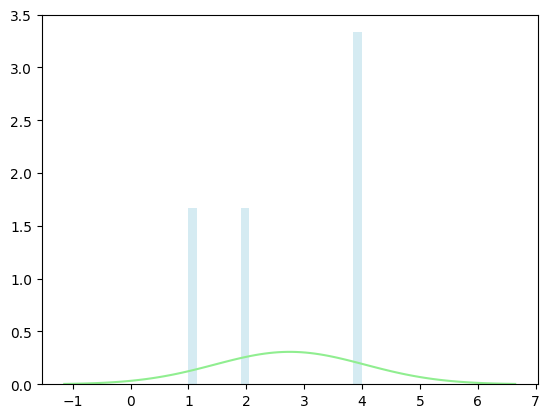

In [22]:
rows = []
r = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    r.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

# plot the gaussian distribution of the period r
x = np.arange(len(r))
y = np.array(r)
mean = np.mean(y)
std_dev = np.std(y)
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
# crea il grafico
plt.plot(x, y, color='lightgreen', label='Gaussian Fit')
plt.hist(r, bins=20, density=True, alpha=0.5, color='lightblue', label='Measured r')



We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm has a chance of failing. These bad results are because $s=0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

Now we have $r$, we might be able to use this to find a factor of $N$. Since:

$$a^r \bmod N = 1 $$

then:

$$(a^r - 1) \bmod N = 0 $$

which means $N$ must divide $a^r-1$. And if $r$ is also even, then we can write:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(if $r$ is not even, we cannot go further and must try again with a different value for $a$). There is then a high probability that the greatest common divisor of $N$ and either $a^{r/2}-1$, or $a^{r/2}+1$ is a proper factor of $N$"

In [ ]:
r=4
guesses = [gcd(a**(r//2)-1, N_const), gcd(a**(r//2)+1, N_const)]
print(guesses)

[3, 5]
